<a href="https://colab.research.google.com/github/fkmoftakhar/hamrah.academy/blob/main/flowers17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.jso

!pip install kaggle

Saving kaggle.json to kaggle.json
chmod: cannot access '/root/.kaggle/kaggle.jso': No such file or directory


In [2]:
!kaggle datasets download -d aima138/17flowerclasses
!unzip -q 17flowerclasses.zip

Dataset URL: https://www.kaggle.com/datasets/aima138/17flowerclasses
License(s): unknown
  0% 0.00/57.8M [00:00<?, ?B/s]
100% 57.8M/57.8M [00:00<00:00, 1.72GB/s]


In [3]:
import os
from PIL import Image

def clean_images(directory):
  removed = 0
  for subdir, _, files in os.walk(directory):
      for file in files:
          filepath = os.path.join(subdir, file)
          try:
              img = Image.open(filepath)
              img.verify()  # Checking image validity
          except (IOError, SyntaxError) as e:
              print(f"Corrupted image removed: {filepath}")
              os.remove(filepath)
              removed += 1
  print(f"Number of images deleted: {removed}")

# Clear train and test
clean_images('train')
clean_images('test')

Number of images deleted: 0
Number of images deleted: 0


## Importing libraries and preparing data

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Data preparation with augmentation to improve accuracy
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Generators (image size 224x224 for MobileNetV2)
train_generator = train_datagen.flow_from_directory(
    '/content/17flowerclasses/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/17flowerclasses/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# classes
class_names = list(train_generator.class_indices.keys())
print("classes:", class_names)

Found 1190 images belonging to 17 classes.
Found 170 images belonging to 17 classes.
classes: ['Bluebell', 'ButterCup', 'ColtsFoot', 'Cowslip', 'Crocus', 'Daffodil', 'Daisy', 'Dandelion', 'Fritillary', 'Iris', 'LilyValley', 'Pansy', 'Snowdrop', 'Sunflower', 'Tigerlily', 'WindFlower', 'tulip']


## Code (model building with transfer learning for high accuracy)

In [5]:
# Load the MobileNetV2 base model (pre-trained on ImageNet)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(17, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,922,577 (11.15 MB)

 Trainable params: 664,593 (2.54 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Model Training

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.3264 - loss: 2.2940 - val_accuracy: 0.7353 - val_loss: 0.8091
Epoch 2/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 404ms/step - accuracy: 0.7460 - loss: 0.7772 - val_accuracy: 0.8294 - val_loss: 0.5340
Epoch 3/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 412ms/step - accuracy: 0.8086 - loss: 0.5951 - val_accuracy: 0.8059 - val_loss: 0.5495
Epoch 4/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 409ms/step - accuracy: 0.8508 - loss: 0.4684 - val_accuracy: 0.8529 - val_loss: 0.4546
Epoch 5/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 400ms/step - accuracy: 0.8897 - loss: 0.3141 - val_accuracy: 0.8706 - val_loss: 0.4231
Epoch 6/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 406ms/step - accuracy: 0.8974 - loss: 0.2984 - val_accuracy: 0.8588 - val_loss: 0.4015
Epoch 7/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 405ms/step - accuracy: 0.9054 - loss: 0.2834 - val_accuracy: 0.8706 - val_loss: 0.3680
Epoch 8/40
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 398ms/step - accuracy: 0.9003 - loss: 0.2871 - val_accurac

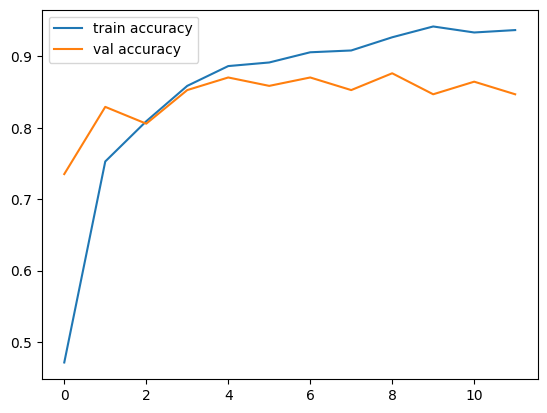

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping to prevent overfit
early_stopping = EarlyStopping(
    monitor='val_loss', # or 'val_accuracy' if you want to focus on accuracy
    patience=5,          # Stop if 5 epochs do not improve
    restore_best_weights=True
)

# Training with 40 epochs and early stopping
history = model.fit(
    train_generator,
    epochs=40,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

# Show history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

## Inference on external images and output display

In [7]:
from tensorflow.keras.preprocessing import image

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


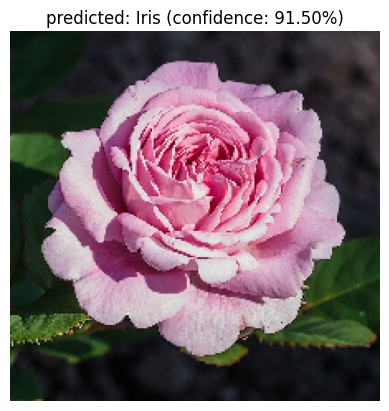

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


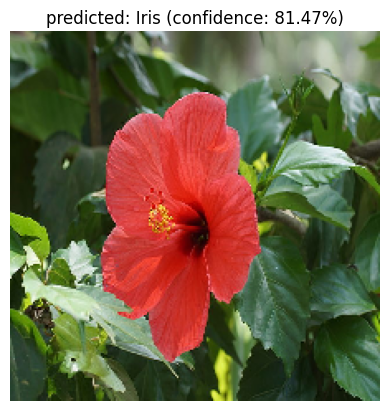

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


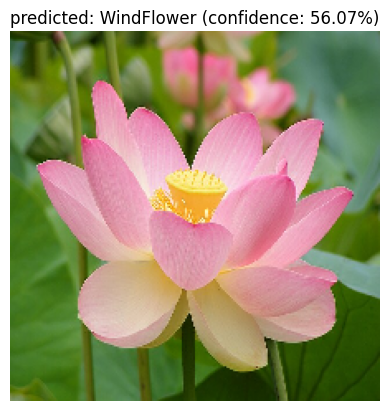

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


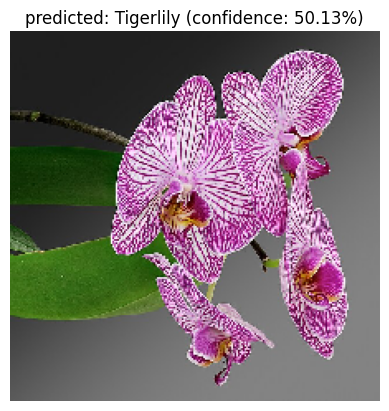

In [8]:
def predict_flower(img_path):
  img = image.load_img(img_path, target_size=(224, 224))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0) / 255.0
  prediction = model.predict(img_array)
  predicted_class = class_names[np.argmax(prediction)]
  confidence = np.max(prediction) * 100
  return predicted_class, confidence, img


# List of images
images = ['./rose.jpg', './Hibiscus.JPG','./Nelumno.jpg','./Orchidaceae.jpg' ]

for img_path in images:
  predicted_class, confidence, img = predict_flower(img_path)
  plt.figure()
  plt.imshow(img)
  plt.title(f"predicted: {predicted_class} (confidence: {confidence:.2f}%)")
  plt.axis('off')
  plt.show()